## Flood Health Vulnerability (FHV) Assessment 1
This notebook analyzes Flood Health Vulnerability (FHV).

In [1]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.stats import pearsonr
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
shape3 = shape3.drop(shape3.columns[[0,1,4,5,6,9,10,11,12,13,14,15]], axis=1)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# Division
shape1 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm1_bbs_20180410.shp')
# # ------------------------------------------------- #

In [2]:
# Load data
data = pd.read_hdf('./data/data.hdf')
data_dist = pd.read_hdf('./data/data_dist.hdf')
data_table = pd.read_hdf('./data/data_table.hdf')
# Add a dot to the district variables
name_dot = data_table['Name'].copy()
name_dot[data_table['Scale'] == "District"] = name_dot[data_table['Scale'] == "District"] + '*'

# Label short names
data_table_temp = data_table.copy()
data_table_temp['Domain'] = data_table_temp['Domain'].replace({'Demographic':'DEMO', 
                                                               'Health':'HEALTH',
                                                               'Social':'SOCIAL',
                                                               'Adaptive Capacity':'COPING CAPACITY',
                                                               'Economic':'ECON',
                                                               'Built':'BUILT'})
data = data[data_table['Name']]

# Re-group to three groups
data_table['Domain'] = data_table['Domain'].replace({'Demographic':'SOCIO-ECONOMIC', 
                                                     'Built':'SOCIO-ECONOMIC', 
                                                     'Social':'SOCIO-ECONOMIC',
                                                     'Economic':'SOCIO-ECONOMIC',
                                                     'Health':'HEALTH',
                                                     'Adaptive Capacity':'COPING CAPACITY'})
domains = data_table['Domain'].unique()
ndm = len(domains)
nvar = np.array([(data_table['Domain'] == dm).sum() for dm in domains])
ndist = data.shape[0]

### (1) Correlation Matrix

In [3]:
# # Correlation Matrix and P-value
# corrmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
# pvalmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# corrmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
# pvalmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# # P-value symbols
# pvalsym = pd.DataFrame(index=corrmat.index, data=np.full(corrmat.shape, ''), 
#                        columns=corrmat.columns)
# pvalsym[pvalmat <= 0.05] = '+'
# pvalsym_dist = pd.DataFrame(index=corrmat_dist.index, data=np.full(corrmat_dist.shape, ''), 
#                             columns=corrmat_dist.columns)
# pvalsym_dist[pvalmat_dist <= 0.05] = '+'
# # - Replace Upazila correaltions to District correlation for district-level variables
# index = data_table[data_table['Scale'] == 'District'].index
# corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
# corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
# corrmat[np.eye(len(corrmat)).astype('bool')] = 0
# pvalsym.iloc[index,:] = pvalsym_dist.iloc[index,:]
# pvalsym.iloc[:,index] = pvalsym_dist.iloc[:,index]
# pvalsym[np.eye(len(pvalsym)).astype('bool')] = ''
# # - Replace name_dot
# corrmat.columns = name_dot; corrmat.index = name_dot
# corrmat.index.name = ''
# corrmat.columns.name = ''

# # Plotting
# sns.set(style="white", font_scale=1)
# cmap=sns.diverging_palette(10, 240, l=55, n=9)
# fig, ax = plt.subplots(figsize=(10,10))
# ax = sns.heatmap(corrmat, ax=ax, vmin=-0.9, vmax=0.9, center=0,
#                  annot=pvalsym, fmt='', annot_kws={"size": 14, 'ha':'center',"va":'center'},
#                  cmap=cmap, square=True,
#                  cbar_kws={'orientation': 'vertical', 'shrink':.5, 'ticks':np.arange(-0.9,1,0.2)})   # [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]})

# # Domains
# sources = data_table_temp['Domain'].tolist()
# for i, source in enumerate(sources):
#     if i and source != sources[i - 1]:
#         # Domain lines
#         ax.axhline(i-0.05, c="w", lw=3)
#         ax.axhline(i-0.05, c="grey", lw=1)
#         ax.axvline(i-0.05, c="w", lw=3)
#         ax.axvline(i-0.05, c="grey", lw=1)
#     if source != sources[i - 1]:
#         # Domain names
#         lx = np.arange(len(corrmat))[np.isin(sources, source)]
#         ax.annotate(source, [np.median(lx)+0.5, -0.4], 
#                     xycoords='data', annotation_clip=False,
#                     color='k', ha='center', fontfamily='sans-serif', fontsize=13)
        
# ax.annotate('+ p < 0.05', [1.1,0.01], xycoords= 'axes fraction',ha='center', fontfamily='sans-serif', fontsize=13, style='italic')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
# plt.tight_layout()
# plt.show()

# # Save a figure
# if False:
#     fn_save = './figures/corrmat.png'
#     fig.savefig(fn_save, bbox_inches='tight')
#     print('%s is saved.' % fn_save)

In [4]:
# # Correlation Matrix and P-value
# corrmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
# pvalmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# corrmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
# pvalmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# # P-value symbols
# pvalsym = pd.DataFrame(index=corrmat.index, data=np.full(corrmat.shape, ''), 
#                        columns=corrmat.columns)
# pvalsym[pvalmat <= 0.05] = '+'
# pvalsym_dist = pd.DataFrame(index=corrmat_dist.index, data=np.full(corrmat_dist.shape, ''), 
#                             columns=corrmat_dist.columns)
# pvalsym_dist[pvalmat_dist <= 0.05] = '+'
# # - Replace Upazila correaltions to District correlation for district-level variables
# index = data_table[data_table['Scale'] == 'District'].index
# corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
# corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
# corrmat[np.eye(len(corrmat)).astype('bool')] = 0
# pvalsym.iloc[index,:] = pvalsym_dist.iloc[index,:]
# pvalsym.iloc[:,index] = pvalsym_dist.iloc[:,index]
# pvalsym[np.eye(len(pvalsym)).astype('bool')] = ''
# # - Replace name_dot
# corrmat.columns = name_dot; corrmat.index = name_dot
# corrmat.index.name = ''
# corrmat.columns.name = ''

# # Plotting
# sns.set(style="white", font_scale=1)
# cmap=sns.diverging_palette(10, 240, l=55, n=9)
# fig, ax = plt.subplots(figsize=(10,10))
# ax = sns.heatmap(corrmat, ax=ax, vmin=-0.9, vmax=0.9, center=0,
#                  annot=pvalsym, fmt='', annot_kws={"size": 14, 'ha':'center',"va":'center'},
#                  cmap=cmap, square=True,
#                  cbar_kws={'orientation': 'vertical', 'shrink':.5, 'ticks':np.arange(-0.9,1,0.2)})   # [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]})

# # Domains
# sources = np.array(data_table_temp['Domain'].tolist())
# sources[np.isin(np.array(sources), ['DEMO','BUILT','SOCIAL','ECON'])] = 'SOCIO-ECONOMIC'
# sources = list(sources)
# for i, source in enumerate(sources):
#     if i and source != sources[i - 1]:
#         # Domain lines
#         ax.axhline(i-0.05, c="w", lw=3)
#         ax.axhline(i-0.05, c="grey", lw=1)
#         ax.axvline(i-0.05, c="w", lw=3)
#         ax.axvline(i-0.05, c="grey", lw=1)
#     if source != sources[i - 1]:
#         # Domain names
#         lx = np.arange(len(corrmat))[np.isin(sources, source)]        
#         ax.annotate(source.capitalize(), [np.median(lx)+0.5, -0.4], 
#                     xycoords='data', annotation_clip=False,
#                     color='k', ha='center', fontfamily='sans-serif', fontsize=14)
        
# ax.annotate('+ p < 0.05', [1.1,0.01], xycoords= 'axes fraction',ha='center', fontfamily='sans-serif', fontsize=13, style='italic')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
# plt.tight_layout()
# plt.show()

# # Save a figure
# if True:
#     fn_save = './figures/corrmat2.png'
#     fig.savefig(fn_save, bbox_inches='tight')
#     print('%s is saved.' % fn_save)

In [5]:
# Changes in indicators' names


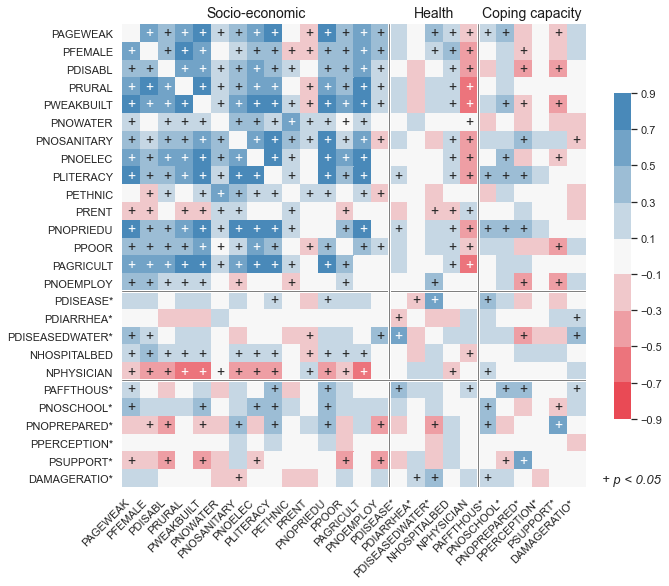

./figures/corrmat2_new.png is saved.


In [6]:
# Correlation Matrix and P-value
corrmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
pvalmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
corrmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
pvalmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# P-value symbols
pvalsym = pd.DataFrame(index=corrmat.index, data=np.full(corrmat.shape, ''), 
                       columns=corrmat.columns)
pvalsym[pvalmat <= 0.05] = '+'
pvalsym_dist = pd.DataFrame(index=corrmat_dist.index, data=np.full(corrmat_dist.shape, ''), 
                            columns=corrmat_dist.columns)
pvalsym_dist[pvalmat_dist <= 0.05] = '+'
# - Replace Upazila correaltions to District correlation for district-level variables
index = data_table[data_table['Scale'] == 'District'].index
corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
corrmat[np.eye(len(corrmat)).astype('bool')] = 0
pvalsym.iloc[index,:] = pvalsym_dist.iloc[index,:]
pvalsym.iloc[:,index] = pvalsym_dist.iloc[:,index]
pvalsym[np.eye(len(pvalsym)).astype('bool')] = ''
# - Replace name_dot
corrmat.columns = name_dot; corrmat.index = name_dot
corrmat.index.name = ''
corrmat.columns.name = ''

# Plotting
sns.set(style="white", font_scale=1)
cmap=sns.diverging_palette(10, 240, l=55, n=9)
cmap[4] = (0.97,0.97,0.97)
# cmap = sns.color_palette(palette='coolwarm_r', n_colors=9, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corrmat, ax=ax, vmin=-0.9, vmax=0.9, center=0,
                 annot=pvalsym, fmt='', annot_kws={"size": 14, 'ha':'center',"va":'center'},
                 cmap=cmap, square=True,
                 cbar_kws={'orientation': 'vertical', 'shrink':.5, 'ticks':np.arange(-0.9,1,0.2)})   # [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]})

# Domains
sources = np.array(data_table_temp['Domain'].tolist())
sources[np.isin(np.array(sources), ['DEMO','BUILT','SOCIAL','ECON'])] = 'SOCIO-ECONOMIC'
sources = list(sources)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        # Domain lines
        ax.axhline(i-0.05, c="w", lw=3)
        ax.axhline(i-0.05, c="grey", lw=1)
        ax.axvline(i-0.05, c="w", lw=3)
        ax.axvline(i-0.05, c="grey", lw=1)
    if source != sources[i - 1]:
        # Domain names
        lx = np.arange(len(corrmat))[np.isin(sources, source)]        
        ax.annotate(source.capitalize(), [np.median(lx)+0.5, -0.4], 
                    xycoords='data', annotation_clip=False,
                    color='k', ha='center', fontfamily='sans-serif', fontsize=14)
        
ax.annotate('+ p < 0.05', [1.1,0.01], xycoords= 'axes fraction',ha='center', fontfamily='sans-serif', fontsize=13, style='italic')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.tight_layout()
plt.show()

# Save a figure
if True:
    fn_save = './figures/corrmat2_new.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (2) PCA analysis
Here, we reduce the dimensions of the three groups: Socio-economic (DEMO, BUILT, SOCIAL, ECONOMIC), Health, and Adaptive capacity.

In [3]:
# Split to the domain-level data
data1 = data[data_table.loc[data_table['Domain'] == 'SOCIO-ECONOMIC', 'Name']]
data2 = data[data_table.loc[data_table['Domain'] == 'HEALTH', 'Name']]
data3 = data[data_table.loc[data_table['Domain'] == 'COPING CAPACITY', 'Name']]
zdata1 = StandardScaler().fit_transform(data1)
zdata2 = StandardScaler().fit_transform(data2)
zdata3 = StandardScaler().fit_transform(data3)

# SoVI with varimax rotation
pca_domain = np.zeros([ndist,ndm])
# SoVI computation
# - Socio-economic
pca = fhv.SPSS_PCA(data1, reduce=True, varimax=True)
scores1, weights1 = pca.scores_rot, pca.weights_rot
comp_mat1, sumsqload1 = pca.comp_mat_rot, pca.sum_sq_load_rot
pca_domain[:,0] = scores1.sum(1)
# - Health
pca = fhv.SPSS_PCA(data2, reduce=True, varimax=True)
scores2, weights2 = pca.scores_rot, pca.weights_rot
comp_mat2, sumsqload2 = pca.comp_mat_rot, pca.sum_sq_load_rot
pca_domain[:,1] = scores2.sum(1)
# - ADAPTIVE CAPACITY
pca = fhv.SPSS_PCA(data3, reduce=True, varimax=True)
scores3, weights3 = pca.scores_rot, pca.weights_rot
comp_mat3, sumsqload3 = pca.comp_mat_rot, pca.sum_sq_load_rot
pca_domain[:,2] = scores3.sum(1)

# Selected Principal Components in each domain
scores = np.hstack([scores1,scores2,scores3])
domain_pcs = pd.DataFrame(StandardScaler().fit_transform(scores), index=data.index.astype('int'), 
                          columns=['pc11','pc12','pc13','pc21','pc22','pc31','pc32','pc33'])
map_pcs = pd.merge(shape3, domain_pcs, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

### (3) Vulnerability Assessments
- (a) Equal-weights vulnerability
- (b) PCA vulnerability

In [4]:
# Empty vulnerability dataframe
vuln = pd.DataFrame(index=data.index.astype('int'))
# (a) Equal-weights vulnerability
equal_domain = np.zeros([data.shape[0],ndm])
for i, dm in enumerate(domains):
    target = data_table['Domain'] == dm
    ewgt = 1/target.sum()
    equal_domain[:,i] = np.dot(data[data_table[target].Name], np.full([target.sum(),1],ewgt)).flatten()
equal_scaled = QuantileTransformer(ndist).fit_transform(equal_domain)
equal_scaled = pd.DataFrame(equal_scaled, index=data.index.astype('int'), columns=['equal1','equal2','equal3'])
vuln = pd.concat([vuln, equal_scaled], axis=1)
vuln['equal'] = equal_scaled.mean(1)
# (b) PCA vulnerability
pca_scaled = QuantileTransformer(n_quantiles=10).fit_transform(pca_domain)
pca_scaled = pd.DataFrame(pca_scaled, index=data.index.astype('int'), columns=['pca1','pca2','pca3'])
vuln = pd.concat([vuln, pca_scaled], axis=1)
vuln['pca'] = pca_scaled.mean(1)
# Save unscaled domain vulnerability
pca_domain = pd.DataFrame(pca_domain, index=data.index.astype('int'), columns=['pca1','pca2','pca3'])
equal_domain = pd.DataFrame(equal_domain, index=data.index.astype('int'), columns=['equal1','equal2','equal3'])
vuln_domain = pd.concat([equal_domain, pca_domain], axis=1)
# - Standardization
vuln_domain = pd.DataFrame(data=StandardScaler().fit_transform(vuln_domain),index=data.index.astype('int'),columns=vuln_domain.columns)

# Merge with shapefile
map_domain = pd.merge(shape3, vuln_domain, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')
map_vuln = pd.merge(shape3, vuln, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

# Save Vulnerability
fn = './data/vuln_calculated_adm3.hdf'
vuln.to_hdf(fn, 'data'); print('%s is saved.' % fn)

./data/vuln_calculated_adm3.hdf is saved.


/Users/dlee/opt/anaconda3/envs/dlee/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_quantiles=544 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [5]:
vuln['equal'].max()

0.9732965009208104

In [6]:
temp = pd.merge(domain_pcs, vuln, left_index=True, right_index=True)
temp.corr().round(2)

,pc11,pc12,pc13,pc21,pc22,pc31,pc32,pc33,equal1,equal2,equal3,equal,pca1,pca2,pca3,pca
pc11,1.00,-0.00,0.00,0.12,-0.51,-0.02,0.34,-0.34,0.87,-0.13,0.17,0.51,0.49,-0.25,0.00,0.16
pc12,-0.00,1.00,-0.00,-0.18,0.08,-0.04,-0.09,-0.11,0.28,-0.10,-0.16,0.02,0.43,-0.09,-0.14,0.13
pc13,0.00,-0.00,1.00,0.11,-0.04,-0.48,-0.04,-0.08,0.05,0.09,-0.35,-0.12,0.66,0.08,-0.34,0.24
pc21,0.12,-0.18,0.11,1.00,-0.00,-0.28,0.22,-0.02,0.08,0.69,-0.07,0.39,0.10,0.76,-0.06,0.48
pc22,-0.51,0.08,-0.04,-0.00,1.00,0.01,0.04,0.31,-0.32,0.48,0.08,0.14,-0.18,0.58,0.19,0.36
pc31,-0.02,-0.04,-0.48,-0.28,0.01,1.00,0.00,0.00,-0.09,-0.23,0.66,0.19,-0.37,-0.23,0.58,-0.00
pc32,0.34,-0.09,-0.04,0.22,0.04,0.00,1.00,-0.00,0.33,0.27,0.70,0.73,0.15,0.20,0.58,0.59
pc33,-0.34,-0.11,-0.08,-0.02,0.31,0.00,-0.00,1.00,-0.26,0.17,0.09,-0.00,-0.21,0.18,0.56,0.33
equal1,0.87,0.28,0.05,0.08,-0.32,-0.09,0.33,-0.26,1.00,-0.06,0.12,0.59,0.67,-0.15,-0.00,0.32
equal2,-0.13,-0.10,0.09,0.69,0.48,-0.23,0.27,0.17,-0.06,1.00,0.04,0.55,0.03,0.91,0.11,0.64


In [7]:
vuln_domain2 = QuantileTransformer(n_quantiles=10).fit_transform(vuln_domain)
vuln_domain2 = pd.DataFrame(data=StandardScaler().fit_transform(vuln_domain2),index=data.index.astype('int'),columns=vuln_domain.columns)
map_domain2 = pd.merge(shape3, vuln_domain2, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

In [8]:
vuln_domain2 - vuln_domain

,equal1,equal2,equal3,pca1,pca2,pca3
ADM3_PCODE,,,,,,
100409,0.102928,0.061755,-0.051628,0.250769,-0.121273,0.332155
100419,-0.410137,0.084986,-0.051628,0.110455,-0.123030,0.332155
100428,-0.306622,0.069096,-0.051628,0.309833,-0.138888,0.332155
100447,-0.360970,0.132695,-0.051628,0.304675,-0.077498,0.332155
100485,-0.031245,0.013846,-0.051628,0.060598,-0.187194,0.332155
...,...,...,...,...,...,...
609141,0.087010,0.174895,0.122624,-0.368264,0.068619,0.110380
609153,0.419391,0.187177,0.122624,0.037654,0.086714,0.110380
609159,0.346480,-0.028249,0.122624,-0.925261,-0.044680,0.110380


### Mapping Domain-level Vulnerabilities (Equal-weight and PCA)

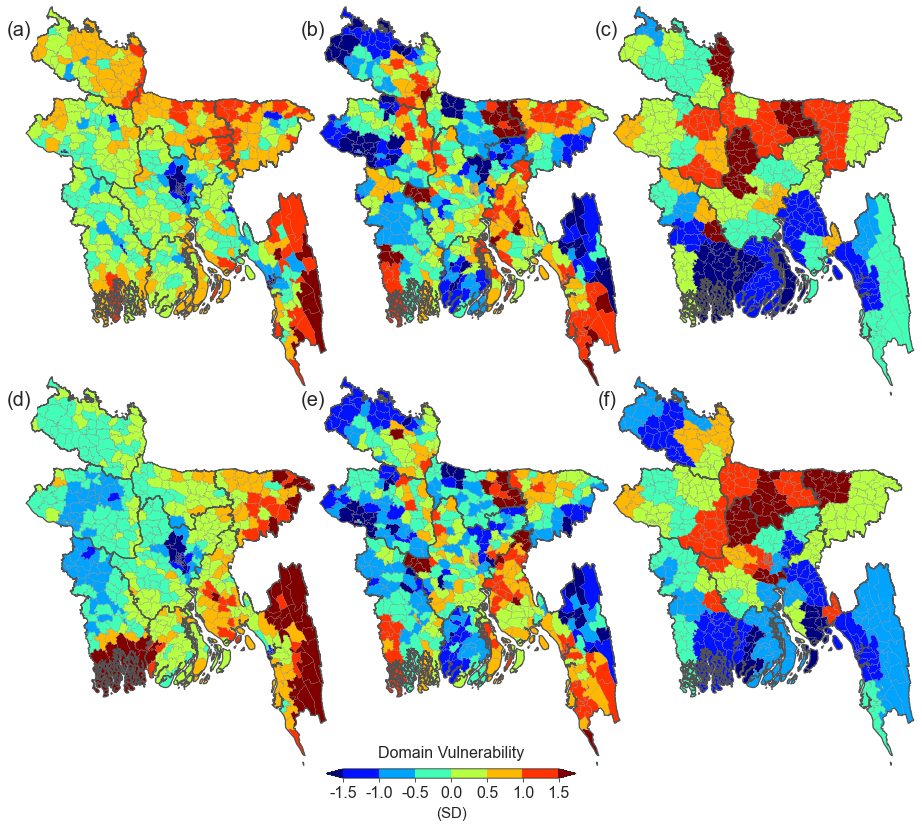

./figures/vulnerability_domain.png is saved.


In [9]:
# Colormap
bounds = list(np.arange(-1.5,1.6,0.5))
boundaries = [-10]+bounds+[110]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)','(b)','(c)','(d)','(e)','(f)']
figlabel = 'Domain Vulnerability'
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,10), facecolor='w')
for (i, el) in enumerate(['equal1','equal2','equal3','pca1','pca2','pca3']):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_domain.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.2, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.02, 0.94), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20, backgroundcolor="w")
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.95, -0.03, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
cbar.ax.annotate('(SD)', xy=(0.5,-3.7),xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15)
plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability_domain.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

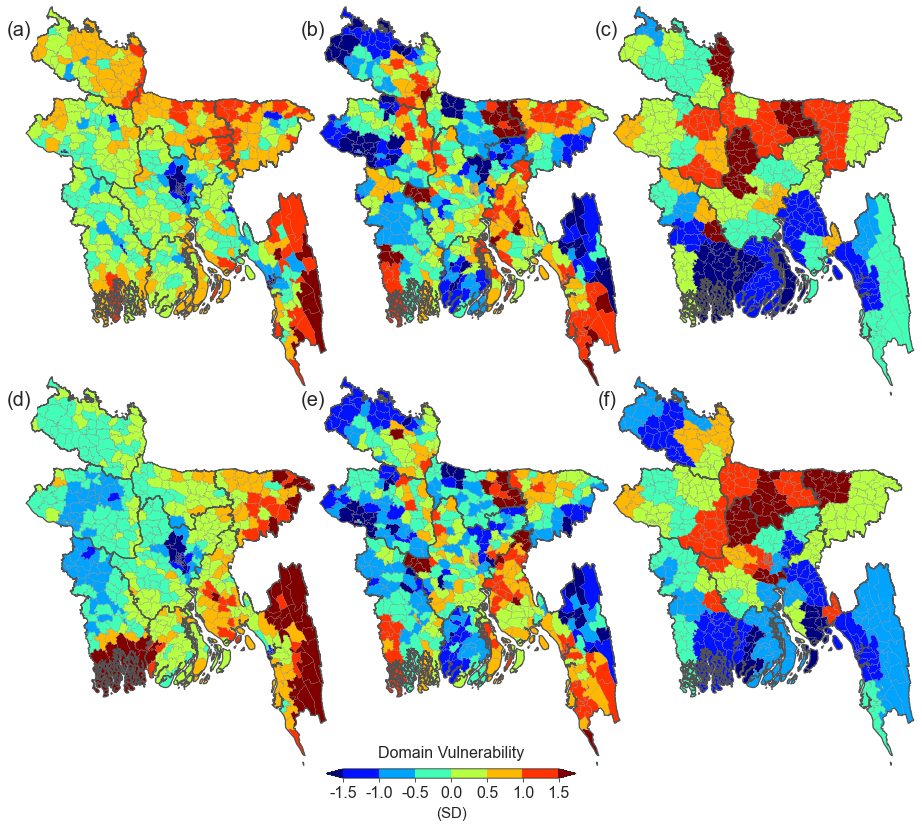

./figures/vulnerability_domain_large.png is saved.


In [15]:
# Colormap
bounds = list(np.arange(-1.5,1.6,0.5))
boundaries = [-10]+bounds+[110]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)','(b)','(c)','(d)','(e)','(f)']
figlabel = 'Domain Vulnerability'
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,10), facecolor='w')
for (i, el) in enumerate(['equal1','equal2','equal3','pca1','pca2','pca3']):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_domain.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.2, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.02, 0.94), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20, backgroundcolor="w")
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.95, -0.03, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
cbar.ax.annotate('(SD)', xy=(0.5,-3.7),xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15)
plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability_domain_large.png'
    fig.savefig(fn_save, bbox_inches='tight',dpi=120)
    print('%s is saved.' % fn_save)

### Mapping Vulnerabilities

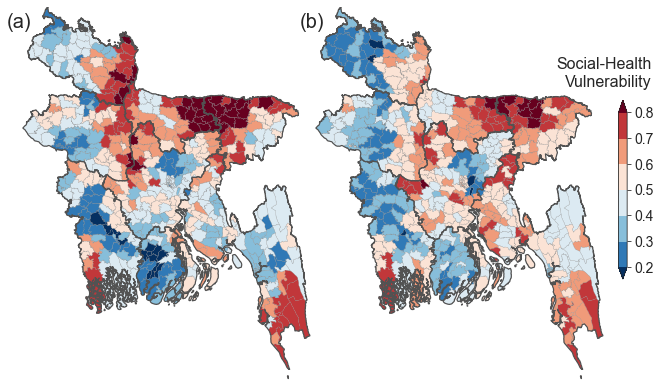

./figures/vulnerability_large.png is saved.


In [20]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Social-Health\nVulnerability'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['equal','pca']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_vuln.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.2, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-1)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    

plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability_large.png'
    fig.savefig(fn_save, bbox_inches='tight', dpi=150)
    print('%s is saved.' % fn_save)

### Selected Principal Components in the Socio-economic domain

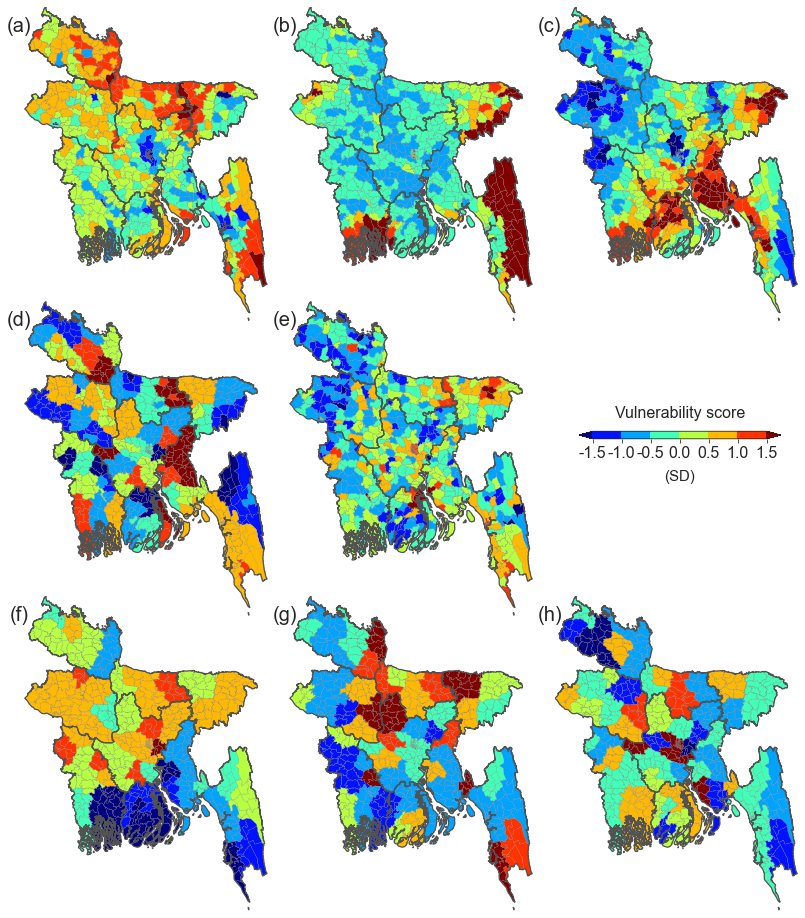

./figures/vulnerability_pca_large.png is saved.


In [22]:
# Colormap
bounds = list(np.arange(-1.5,1.6,0.5))
boundaries = [-10]+bounds+[110]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)','(b)','(c)','(d)','(e)','','(f)','(g)','(h)']
figlabel = 'Vulnerability score'
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(11,12), facecolor='w')
for (i, el) in enumerate(['pc11','pc12','pc13','pc21','pc22','pc23','pc31','pc32','pc33']):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    if i != 5:
        map_pcs.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.2, edgecolor='grey')
        ax.annotate(fignumb[i], xy=(-0.02, 0.94), xycoords='axes fraction',
                    horizontalalignment='center', verticalalignment='center',
                    fontname='arial',fontsize=20)
        shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0.1, 1.5, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
cbar.ax.annotate('(SD)', xy=(0.5,-5),xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15)
plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability_pca_large.png'
    fig.savefig(fn_save, bbox_inches='tight', dpi=100)
    print('%s is saved.' % fn_save)

### Export data (Zenodo)

In [16]:
# Convert ADM3_PCODE of Mymensingh (45) division (45 -> 30)
# - Admin level 3
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
pcode3_45 = shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].values.astype(int)
pcode3_30 = ('30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:].values).astype(int)
change3_4530 = {k:v for k,v in zip(pcode3_45, pcode3_30)}
change3_3045 = {v:k for k,v in change3_4530.items()}
# - Admin level 2
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
pcode2_45 = shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].values.astype(int)
pcode2_30 = ('30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:].values).astype(int)
change2_4530 = {k:v for k,v in zip(pcode2_45, pcode2_30)}
change2_3045 = {v:k for k,v in change2_4530.items()}

# Modify output
# - Admin level 3
name_col = {'equal1': 'EQL_SOCIO',
            'equal2': 'EQL_HEALTH',
            'equal3': 'EQL_COPING',
            'equal': 'EQL_SHV',
            'pca1': 'PCA_SOCIO',
            'pca2': 'PCA_HEALTH',
            'pca3': 'PCA_COPING',
            'pca': 'PCA_SHV'
           }
output3 = map_vuln.copy()
output3['ADM3_PCODE'].replace(change3_3045, inplace=True)
output3 = output3[['ADM3_PCODE', 'ADM3_EN', 'equal1', 'equal2', 'equal3', 'equal', 'pca1', 'pca2', 'pca3', 'pca', 'geometry']]
output3 = output3.rename(columns=name_col)
output3['ADM3_PCODE'] = output3['ADM3_PCODE'].values.astype(int)
shape3[['ADM1_PCODE', 'ADM2_PCODE', 'ADM3_PCODE']] = shape3[['ADM1_PCODE', 'ADM2_PCODE', 'ADM3_PCODE']].values.astype(int)
shape3 = shape3.merge(output3[['ADM3_PCODE', *list(name_col.values())]], on='ADM3_PCODE')
output3 = shape3[['ADM0_EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_PCODE',
                  'ADM2_EN', 'ADM2_PCODE', 'ADM3_EN', 'ADM3_PCODE',
                  'EQL_SOCIO', 'EQL_HEALTH', 'EQL_COPING', 'EQL_SHV',
                  'PCA_SOCIO', 'PCA_HEALTH', 'PCA_COPING', 'PCA_SHV',
                  'geometry']]
# - Admin level 2
name_col = {'EQUAL1': 'EQL_SOCIO',
            'EQUAL2': 'EQL_HEALTH',
            'EQUAL3': 'EQL_COPING',
            'EQUAL': 'EQL_SHV',
            'PCA1': 'PCA_SOCIO',
            'PCA2': 'PCA_HEALTH',
            'PCA3': 'PCA_COPING',
            'PCA': 'PCA_SHV'
           }
output2 = gpd.read_file('./data/mapdata2.hdf')
output2['ADM2_PCODE'].replace(change2_3045, inplace=True)
output2 = output2[['ADM2_PCODE', 'ADM2_EN', 'EQUAL', 'EQUAL1', 'EQUAL2', 'EQUAL3', 'PCA', 'PCA1', 'PCA2', 'PCA3', 'geometry']]
output2 = output2.rename(columns=name_col)
output2['ADM2_PCODE'] = output2['ADM2_PCODE'].values.astype(int)
shape2[['ADM1_PCODE', 'ADM2_PCODE']] = shape2[['ADM1_PCODE', 'ADM2_PCODE']].values.astype(int)
shape2 = shape2.merge(output2[['ADM2_PCODE', *list(name_col.values())]], on='ADM2_PCODE')
output2 = shape2[['ADM0_EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_PCODE',
                  'ADM2_EN', 'ADM2_PCODE',
                  'EQL_SOCIO', 'EQL_HEALTH', 'EQL_COPING', 'EQL_SHV',
                  'PCA_SOCIO', 'PCA_HEALTH', 'PCA_COPING', 'PCA_SHV',
                  'geometry']]
# Scale data from 0 to 1 using the Max/Min 
col_target = ['EQL_SOCIO', 'EQL_HEALTH', 'EQL_COPING','PCA_SOCIO', 'PCA_HEALTH', 'PCA_COPING']
scaler = MinMaxScaler()
output2.loc[:, col_target] = scaler.fit_transform(output2[col_target])


# Raw data
scaled_data = data.copy()
scaled_data = scaled_data.reset_index().replace(change3_3045)
scaled_data = scaled_data.sort_values('ADM3_PCODE').reset_index(drop=True)
scaled_data_dist = data_dist.copy()
scaled_data_dist = scaled_data_dist.reset_index().replace(change2_3045)
scaled_data_dist = scaled_data_dist.sort_values('ADM2_PCODE').reset_index(drop=True)
raw_data = pd.read_hdf('./data/raw_data.hdf')
raw_data_dist = pd.read_hdf('./data/raw_data_dist.hdf')
raw_data = raw_data.reset_index().replace(change3_3045)
raw_data = raw_data.sort_values('ADM3_PCODE').reset_index(drop=True)
raw_data_dist = raw_data_dist.reset_index().replace(change2_3045)
raw_data_dist = raw_data_dist.sort_values('ADM2_PCODE').reset_index(drop=True)
raw_data_table = pd.read_hdf('./data/raw_data_table.hdf')


# Name change
name_change = {'PAGEWEAK': 'P_WEAK-AGE', 
               'PFEMALE': 'P_FEMALE', 
               'PDISABL': 'P_DISABLE',
               'PRURAL': 'P_RURAL', 
               'PWEAKBUILT': 'P_WEAK-HOUSE',
               'PNOWATER': 'P_WATER-SUPPLY', 
               'PNOSANITARY': 'P_SANITATION', 
               'PNOELEC': 'P_ELECTRICITY',
               'PLITERACY': 'P_LITERACY',
               'PETHNIC': 'P_ETHNIC',
               'PRENT': 'P_RENT',
               'PNOPRIEDU': 'P_EDUCATION', 
               'PPOOR': 'P_POOR',
               'PAGRICULT': 'P_AGRICULTURE', 
               'PNOEMPLOY': 'P_EMPLOYMENT',
               'PDISEASE': 'P_DISEASE', 
               'PDIARRHEA': 'P_DIARRHEA', 
               'PDISEASEDWATER': 'P_WATER-DISEASE', 
               'NHOSPITALBED': 'N_HOSPITAL-BED',
               'NPHYSICIAN': 'N_PHYSICIAN', 
               'PAFFTHOUS': 'P_HOUSE-AFFECTED', 
               'PNOSCHOOL': 'P_CHILD-SCHOOL', 
               'PNOPREPARED': 'P_PREPAREDNESS',
               'PPERCEPTION': 'P_PERCEPTION', 
               'PSUPPORT': 'P_SUPPORT', 
               'DAMAGERATIO': 'R_DAMAGE-INCOME'}
raw_data_table = raw_data_table.replace(name_change)
raw_data = raw_data.rename(columns=name_change)
raw_data_dist = raw_data_dist.rename(columns=name_change)
scaled_data = scaled_data.rename(columns=name_change)
scaled_data_dist = scaled_data_dist.rename(columns=name_change)

# Merge datasets
raw_data.columns = ['ADM3_PCODE', *['RAW_' + col for col in raw_data.columns[1:]]]
raw_data_dist.columns = ['ADM2_PCODE', *['RAW_' + col for col in raw_data_dist.columns[1:]]]
scaled_data.columns = ['ADM3_PCODE', *['SCALED_' + col for col in scaled_data.columns[1:]]]
scaled_data_dist.columns = ['ADM2_PCODE', *['SCALED_' + col for col in scaled_data_dist.columns[1:]]]
merged_data = pd.merge(raw_data, scaled_data, on='ADM3_PCODE')
merged_data_dist = pd.merge(raw_data_dist, scaled_data_dist, on='ADM2_PCODE')
# - Add heads
head3 = shape3[['ADM0_EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_PCODE','ADM2_EN', 'ADM2_PCODE', 'ADM3_EN', 'ADM3_PCODE']]
merged_data = head3.merge(merged_data, on='ADM3_PCODE')
head2 = shape2[['ADM0_EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_PCODE','ADM2_EN', 'ADM2_PCODE']]
merged_data_dist = head2.merge(merged_data_dist, on='ADM2_PCODE')
# - Merge all
merged_data = pd.merge(merged_data, output3[['ADM3_PCODE','EQL_SOCIO','EQL_HEALTH','EQL_COPING','EQL_SHV',
                                             'PCA_SOCIO','PCA_HEALTH','PCA_COPING','PCA_SHV']], on='ADM3_PCODE')
merged_data_dist = pd.merge(merged_data_dist, output2[['ADM2_PCODE','EQL_SOCIO','EQL_HEALTH','EQL_COPING','EQL_SHV',
                                                       'PCA_SOCIO','PCA_HEALTH','PCA_COPING','PCA_SHV']], on='ADM2_PCODE')

# Saving to CSV and Shapefile
fn_out = './data_zenodo/metadata_indicators.csv'
raw_data_table.to_csv(fn_out)
print('%s is saved.' % fn_out)
fn_out = './data_zenodo/adm3_indicators.csv'
merged_data.to_csv(fn_out)
print('%s is saved.' % fn_out)
fn_out = './data_zenodo/adm2_indicators.csv'
merged_data_dist.to_csv(fn_out)
print('%s is saved.' % fn_out)
fn_out = './data_zenodo/adm3_vulnerability.shp'
output3.to_file(fn_out)
print('%s is saved.' % fn_out)
fn_out = './data_zenodo/adm2_vulnerability.shp'
output2.to_file(fn_out)
print('%s is saved.' % fn_out)

./data_zenodo/metadata_indicators.csv is saved.
./data_zenodo/adm3_indicators.csv is saved.
./data_zenodo/adm2_indicators.csv is saved.
./data_zenodo/adm3_vulnerability.shp is saved.
./data_zenodo/adm2_vulnerability.shp is saved.


In [17]:
merged_data

,ADM0_EN,ADM0_PCODE,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,RAW_P_WEAK-AGE,RAW_P_FEMALE,...,SCALED_P_SUPPORT,SCALED_R_DAMAGE-INCOME,EQL_SOCIO,EQL_HEALTH,EQL_COPING,EQL_SHV,PCA_SOCIO,PCA_HEALTH,PCA_COPING,PCA_SHV
0,Bangladesh,BD,Khulna,40,Jessore,4041,Abhaynagar,404104,0.124005,0.497603,...,0.622551,0.058937,0.165746,0.224678,0.179558,0.189994,0.203288,0.348758,0.222222,0.258089
1,Bangladesh,BD,Dhaka,30,Dhaka,3026,Adabor,302602,0.101599,0.463922,...,0.755723,0.561285,0.060773,0.686924,0.645488,0.464395,0.055732,0.679896,0.816058,0.517229
2,Bangladesh,BD,Rajshahi,50,Bogra,5010,Adamdighi,501006,0.118861,0.501153,...,0.847710,0.088257,0.215470,0.476980,0.844383,0.512277,0.204777,0.392958,0.617931,0.405222
3,Bangladesh,BD,Rangpur,55,Lalmonirhat,5552,Aditmari,555202,0.144255,0.500690,...,0.654439,0.125473,0.736648,0.023941,0.390424,0.383671,0.533695,0.066289,0.333333,0.311106
4,Bangladesh,BD,Barisal,10,Barisal,1006,Agailjhara,100602,0.136769,0.515429,...,0.628851,0.389716,0.534070,0.440147,0.220074,0.398097,0.822142,0.112631,0.281157,0.405310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,Bangladesh,BD,Dhaka,30,Dhaka,3026,Uttara,302695,0.081803,0.436659,...,0.755723,0.561285,0.036832,0.657459,0.645488,0.446593,0.083084,0.713209,0.816058,0.537450
540,Bangladesh,BD,Barisal,10,Barisal,1006,Wazirpur,100694,0.141982,0.516814,...,0.628851,0.389716,0.475138,0.508287,0.220074,0.401166,0.735830,0.187229,0.281157,0.401405
541,Bangladesh,BD,Sylhet,60,Sylhet,6091,Zakiganj,609194,0.154763,0.505122,...,0.619459,0.238671,0.808471,0.552486,0.582873,0.647944,0.937602,0.313366,0.647198,0.632722
542,Bangladesh,BD,Dhaka,30,Shariatpur,3086,Zanjira,308694,0.153176,0.504992,...,0.575597,0.112079,0.734807,0.480663,0.269797,0.495089,0.691136,0.502267,0.334575,0.509326
